# The most circular lakes in the US

Lake shapes have a lot of cool properties. As they get larger, their shorelines become more complex. The rate at which this happens is related to the fractal nature of Earth's surface.

Let's find the most "circular" lake in each state. I use "circular" in quotes because we don't just be calculating percent overlap with a circle. Since lakes become less complex as they get smaller, the lakes with the greatest overlap with a circle will just be the smallest ones. That's not very much fun! Instead, let's calculate a circle score as the product of percent overlap with a circle of equivalent area and the base-10 logarithm of lake area. This index has no physical basis, but it will identify lakes that are both quite circular and large in area.

## 1. Download data

The [LAGOS](https://lagoslakes.org/) research team has done an amazing job at compiling lake data. Their LAGOS-US LOCUS dataset compiles shoreline boundaries for all lakes larger than 1 ha in the continental US. Run the below shell commands to get the data on your machine.

## 2. Reading in chunks

The data is too large to fit into memory without breaking our 1 GB rule. Instead, we will have to read the data in chunks, compute what we need to identify the most circular lakes, and then pull only the geometries we need for the final map.

In [1]:
from osgeo import ogr
ogr.UseExceptions()
import geopandas as gpd
import fiona

dataset = "gis_locus_v1.0.gpkg"

# Get number of features
ds = ogr.Open(dataset)
n_feats = ds.GetLayer(0).GetFeatureCount()
print("Number of features:", n_feats)
ds = None

Number of features: 479950


There are so many polygons that we cannot safely read the whole dataset into memory. Instead we can read the full polygon data in chunks and compute what we need.

In [2]:
chunk_size = n_feats // 20

def enumerate_chunks(chunk_size, stop):
    upto = 0
    while upto < stop:
        # Add one because slice object are right-exclusive
        next = min(stop+1, upto+chunk_size)
        yield upto, next
        upto = next

for tup in enumerate_chunks(chunk_size, n_feats):
    print(tup)

(0, 23997)
(23997, 47994)
(47994, 71991)
(71991, 95988)
(95988, 119985)
(119985, 143982)
(143982, 167979)
(167979, 191976)
(191976, 215973)
(215973, 239970)
(239970, 263967)
(263967, 287964)
(287964, 311961)
(311961, 335958)
(335958, 359955)
(359955, 383952)
(383952, 407949)
(407949, 431946)
(431946, 455943)
(455943, 479940)
(479940, 479951)


In [3]:
%%time
# Iterate over chunks and retain:
# - feature id
# - centroid
# - overlap
# - area

import shapely
import numpy as np
import pandas as pd

def circle_of_same_area(shape):
    radius = np.sqrt(shape.area / np.pi)
    circle = shapely.centroid(shape).buffer(radius)
    return circle
    
def overlap_with_circle(shape):
    circle = circle_of_same_area(shape)
    
    return circle.intersection(shape).area / circle.area

def read_chunk_get_summary(chunk_tuple):
    this_chunk = gpd.read_file(dataset, rows=slice(*chunk_tuple), layer="lake")
    this_chunk["centroid"] = shapely.centroid(this_chunk.geometry)
    this_chunk["overlap"] = this_chunk.geometry.apply(overlap_with_circle)
    this_chunk["circle_score"] = this_chunk["overlap"] * np.log10(this_chunk["Shape_Area"])
    return this_chunk[["lagoslakeid", "Shape_Area", "overlap", "centroid", "circle_score"]]

summary_df = pd.concat((read_chunk_get_summary(ch) for ch in enumerate_chunks(chunk_size, n_feats)))    

CPU times: user 1min 51s, sys: 6.51 s, total: 1min 57s
Wall time: 2min 36s


In [4]:
summary_df.head()

,lagoslakeid,Shape_Area,overlap,centroid,circle_score
0,8056,1.419346e+06,0.424470,POINT (2000527.751 2870429.359),2.611375
1,19412,6.622414e+05,0.576911,POINT (2042476.018 2884051.412),3.358211
2,7956,1.039985e+07,0.517913,POINT (2057342.125 2945413.932),3.634207
3,68446,4.199498e+05,0.362278,POINT (2068455.415 2915550.534),2.037163
4,7940,6.070841e+05,0.389642,POINT (2132856.882 2952963.138),2.253399


## 3. Winners by state

We now attach a state attribute to each lake and find the most circular lake in each state.

In [5]:
summary_df = summary_df.set_geometry("centroid").set_crs(epsg=5070)

In [6]:
# Join state attribute onto the shapes
states = gpd.read_file("cb_2018_us_state_5m.shp")[["NAME", "geometry"]].to_crs(epsg=5070)

summary_df_join = summary_df.sjoin(states, how="left")
summary_df_join.head()

,lagoslakeid,Shape_Area,overlap,centroid,circle_score,index_right,NAME
0,8056,1.419346e+06,0.424470,POINT (2000527.751 2870429.359),2.611375,44.0,Maine
1,19412,6.622414e+05,0.576911,POINT (2042476.018 2884051.412),3.358211,44.0,Maine
2,7956,1.039985e+07,0.517913,POINT (2057342.125 2945413.932),3.634207,44.0,Maine
3,68446,4.199498e+05,0.362278,POINT (2068455.415 2915550.534),2.037163,44.0,Maine
4,7940,6.070841e+05,0.389642,POINT (2132856.882 2952963.138),2.253399,44.0,Maine


In [7]:
# Take the most circular lake from each state
most_circular = summary_df_join\
    .sort_values('circle_score', ascending=False)\
    .groupby('NAME')\
    .apply(pd.DataFrame.head, n=1, include_groups=False)\
    .reset_index(level="NAME")

most_circular.head()

,NAME,lagoslakeid,Shape_Area,overlap,centroid,circle_score,index_right
15147,Alabama,247440,7.847888e+06,0.858758,POINT (762610.46 885797.248),5.920924,8.0
18509,Arizona,453937,1.255180e+07,0.839000,POINT (-1393671.747 1434195.625),5.955818,28.0
20698,Arkansas,408132,1.130558e+08,0.733540,POINT (184591.612 1188877.067),5.907414,52.0
23307,California,482796,1.833175e+08,0.832898,POINT (-1982140.233 1904870.411),6.882404,5.0
10564,Colorado,360516,9.852425e+06,0.864924,POINT (-678669.775 1959729.048),6.048881,31.0


## 4. Recollect geometries

Now we go back through the original data source and only keep those lake ids we have identified as most circular.

In [8]:
# Read in the full geometries of the most circular lakes
idx_to_read = most_circular.lagoslakeid.values

def records(file, idx):
    with fiona.open(file, layer="lake") as source:
        for i, feat in enumerate(source):
            if feat.properties["lagoslakeid"] in idx:
                yield feat

full_geometry = gpd.GeoDataFrame.from_features(records(dataset, idx_to_read)).set_crs(epsg=5070)

In [9]:
# Reattach state name
full_geometry_join = pd.merge(full_geometry, most_circular[["lagoslakeid", "circle_score", "overlap", "NAME"]],
                              how="left", on="lagoslakeid")
full_geometry_join.sort_values("NAME", inplace=True)
full_geometry_join.reset_index(inplace=True)

In [10]:
# Calculate circle geometry
full_geometry_join["circle"] = full_geometry_join.geometry.apply(circle_of_same_area)

## 5. Plotting!

Now we plot each lake polygon overlaid with a circle of the same area.

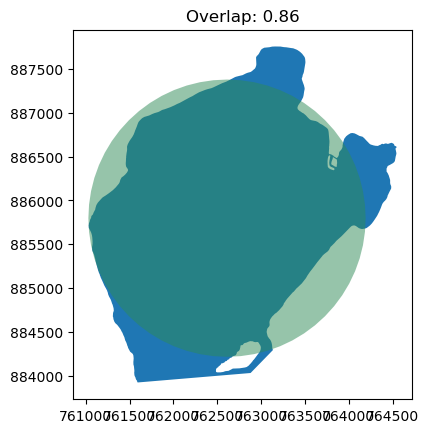

In [11]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

poly = full_geometry_join.geometry[0]
circle = full_geometry_join.circle[0]
overlap = full_geometry_join.overlap[0]

gpd.GeoSeries(poly).plot(ax=ax)
gpd.GeoSeries(circle).plot(ax=ax, color="seagreen", alpha=0.5)
ax.set_title("Overlap: {:.2f}".format(overlap))
plt.show()

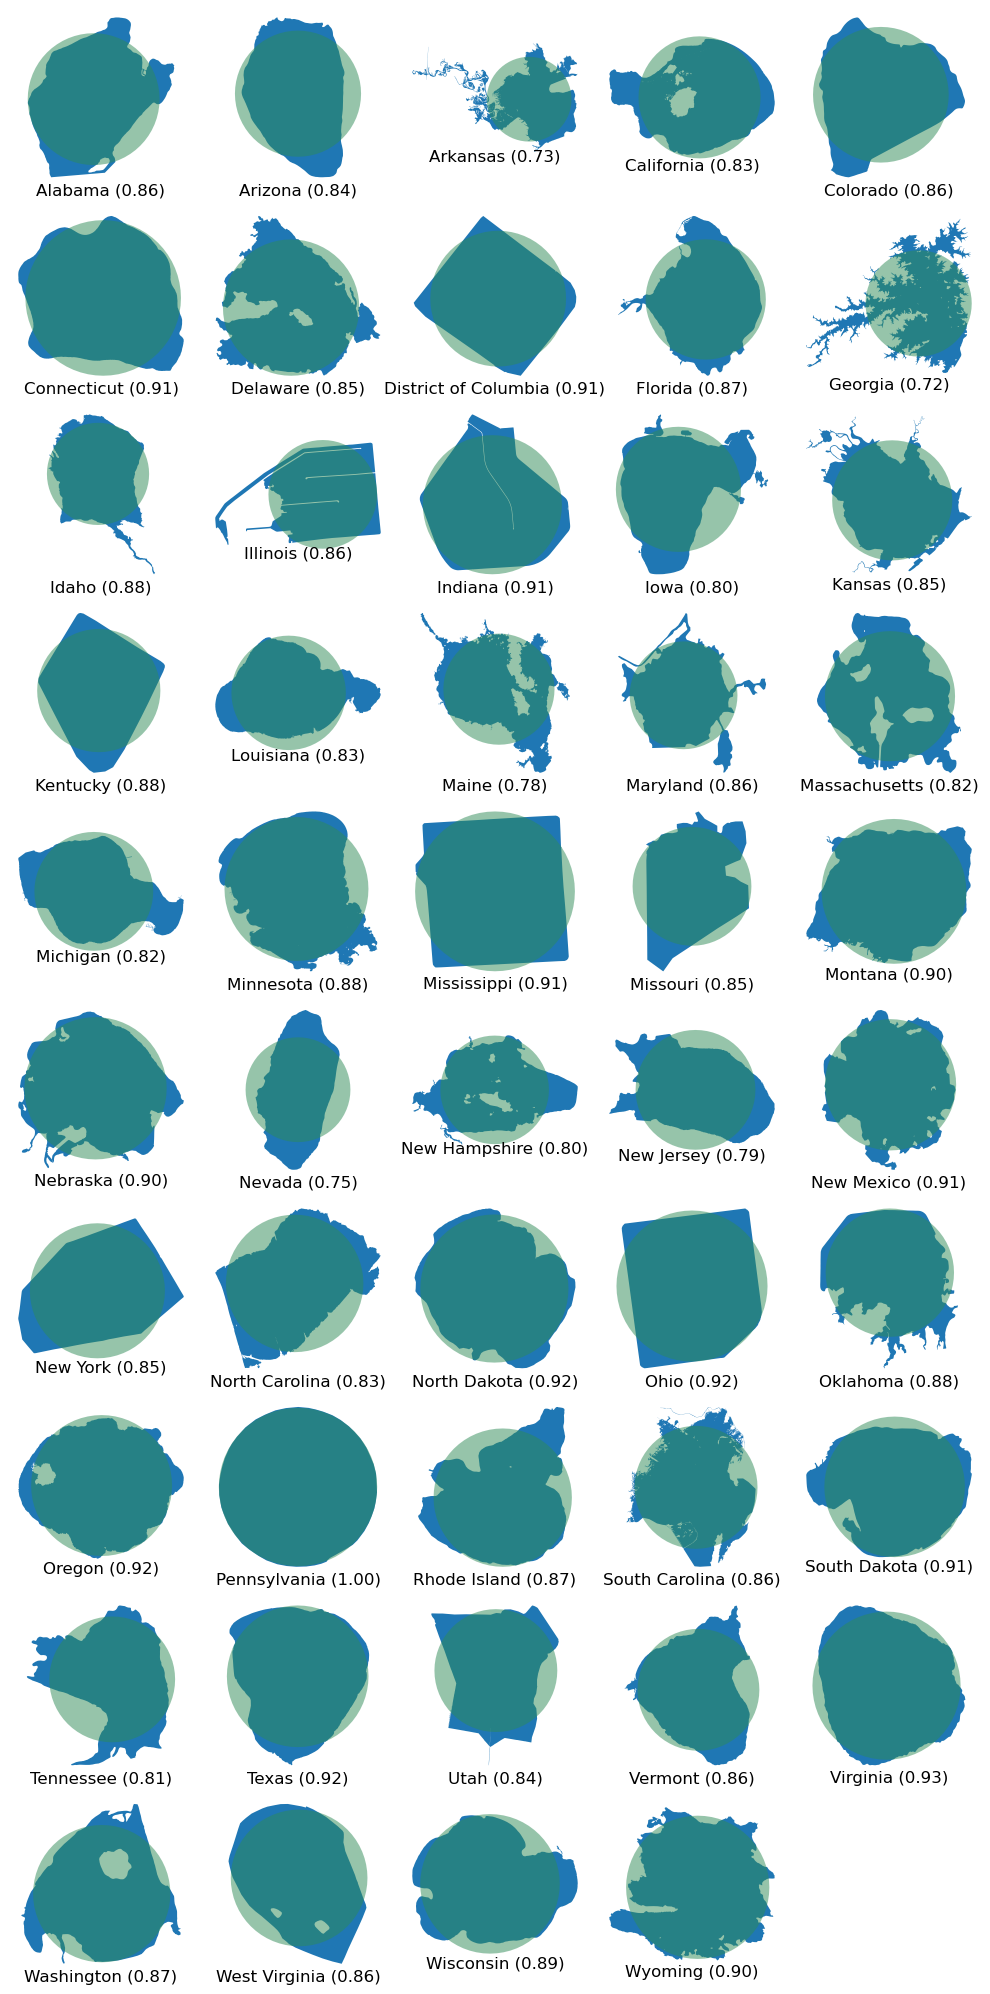

In [12]:
fig, axes = plt.subplots(10, 5)
fig.set_size_inches(10, 20)

for i, ax in enumerate(axes.flat):
    if i >= full_geometry_join.shape[0]: continue
        
    poly = full_geometry_join.geometry[i]
    circle = full_geometry_join.circle[i]
    name = full_geometry_join.NAME[i]
    overlap = full_geometry_join.overlap[i]

    gpd.GeoSeries(poly).plot(ax=ax)
    gpd.GeoSeries(circle).plot(ax=ax, color="seagreen", alpha=0.5)

    ax.set_title(name + " ({:.2f})".format(overlap), y=-0.1)

for ax in axes.flat: ax.set_axis_off()

fig.tight_layout()
plt.show()

In [13]:
# Now plot everybody on a map
import folium

m = folium.Map(location=[39.8, -98.6], zoom_start=4)

for pt in full_geometry_join.geometry.apply(shapely.centroid).to_crs(epsg=4326):
    folium.Marker(
        location=[pt.y, pt.x], # coordinates for the marker (Earth Lab at CU Boulder)
        icon=folium.Icon()
    ).add_to(m)

m